# Proyek Analisis Data: E-Commerce Public
- **Nama:** Nurul Baroroh
- **Email:** 25nurulbaroroh@gmail.com
- **ID Dicoding:** nurul_baroroh_8nEh

## Menentukan Pertanyaan Bisnis

- Pertanyaan 1

> Bagaimana tren penjualan e-commerce berdasarkan waktu dan kategori produk?

- Pertanyaan 2

>Bagaimana segmentasi pelanggan berdasarkan perilaku transaksi menggunakan analisis RFM?

## Import Semua Packages/Library yang Digunakan

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

## Data Wrangling

### Gathering Data

In [6]:
customers = pd.read_csv('customers_dataset.csv')
orders = pd.read_csv('orders_dataset.csv')
order_items = pd.read_csv('order_items_dataset.csv')
products = pd.read_csv('products_dataset.csv')
category_translation = pd.read_csv('product_category_name_translation.csv')

### Assessing Data

In [7]:
# Informasi struktur data
customers.info()
orders.info()
order_items.info()
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4

### Cleaning Data

In [8]:
df = pd.merge(orders, customers, on='customer_id', how='left')
df = pd.merge(df, order_items, on='order_id', how='left')
df = pd.merge(df, products, on='product_id', how='left')
df = pd.merge(df, category_translation, on='product_category_name', how='left')

df.isna().sum()

,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,161
order_delivered_carrier_date,1968
order_delivered_customer_date,3229
order_estimated_delivery_date,0
customer_unique_id,0
customer_zip_code_prefix,0


In [9]:
df.duplicated().sum()

np.int64(0)

**Insight:**
Setelah proses penggabungan data, ditemukan missing value pada beberapa kolom. Missing value pada kolom tanggal pengiriman disebabkan oleh pesanan yang belum selesai diproses. Selain itu, missing value pada kolom order item muncul akibat adanya pesanan tanpa item produk. Sementara itu, missing value pada kategori produk menunjukkan bahwa sebagian produk tidak memiliki informasi kategori. Penanganan missing value dilakukan secara selektif sesuai dengan kebutuhan analisis


### Cleaning Data

In [10]:
# Konversi kolom waktu ke datetime
date_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'shipping_limit_date'
]

for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

In [11]:
# Fokus pada pesanan yang telah selesai
df = df[df['order_status'] == 'delivered']

In [12]:
# Menghapus order tanpa produk
df = df.dropna(subset=['product_id', 'price', 'freight_value'])

Tangani Missing Kategori Produk

In [13]:
df['product_category_name_english'] = df['product_category_name_english'].fillna('Unknown')

In [14]:
# Drop kolom yang tidak relevan untuk analisis
cols_to_drop = [
    'product_name_lenght',
    'product_description_lenght',
    'product_photos_qty',
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm'
]

df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

In [15]:
df.isna().sum()

,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,15
order_delivered_carrier_date,2
order_delivered_customer_date,8
order_estimated_delivery_date,0
customer_unique_id,0
customer_zip_code_prefix,0


**Insight:**
- Proses pembersihan data dilakukan secara selektif berdasarkan kebutuhan analisis. Pesanan yang belum selesai dihapus karena tidak merepresentasikan transaksi aktual. Order tanpa item produk juga dihapus karena tidak relevan dalam perhitungan penjualan dan segmentasi pelanggan. Sementara itu, kategori produk yang tidak tersedia diisi dengan label Unknown agar transaksi tetap dapat dianalisis tanpa menghilangkan data yang valid.

## Exploratory Data Analysis (EDA)

### EDA - Pertanyaan 1

In [16]:
df.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,order_item_id,shipping_limit_date,price,freight_value
count,110197,110182,110195,110189,110197,110197.000000,110197.000000,110197,110197.000000,110197.000000
mean,2018-01-02 02:49:51.928346368,2018-01-02 14:24:00.336697856,2018-01-05 09:42:32.069540352,2018-01-14 13:59:34.689261056,2018-01-25 22:07:57.552020224,35155.346888,1.198181,2018-01-08 17:18:50.631142400,119.980563,19.948598
min,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-04 00:00:00,1003.000000,1.000000,2016-09-19 23:11:33,0.850000,0.000000
25%,2017-09-15 06:32:42,2017-09-15 14:55:28,2017-09-18 22:26:15.500000,2017-09-26 20:15:35,2017-10-06 00:00:00,11310.000000,1.000000,2017-09-21 14:55:25,39.900000,13.080000
50%,2018-01-21 10:11:55,2018-01-22 13:57:18.500000,2018-01-24 18:52:54,2018-02-02 21:05:09,2018-02-16 00:00:00,24344.000000,1.000000,2018-01-26 20:16:13,74.900000,16.260000
75%,2018-05-05 16:03:59,2018-05-05 23:10:37.750000128,2018-05-08 14:20:30,2018-05-15 20:14:33,2018-05-28 00:00:00,59066.000000,1.000000,2018-05-10 20:30:37,134.170000,21.150000
max,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,99980.000000,21.000000,2020-04-09 22:35:08,6735.000000,409.680000
std,NaN,NaN,NaN,NaN,NaN,29901.148745,0.706676,NaN,182.299446,15.698136


In [17]:
# Total penjualan per item
df['total_sales'] = df['price'] + df['freight_value']

# Ekstraksi tahun dan bulan
df['order_year'] = df['order_purchase_timestamp'].dt.year
df['order_month'] = df['order_purchase_timestamp'].dt.month
df['order_year_month'] = df['order_purchase_timestamp'].dt.to_period('M')

In [18]:
df[['total_sales']].describe()

,total_sales
count,110197.000000
mean,139.929161
std,189.319151
min,6.080000
25%,55.180000
50%,92.130000
75%,157.510000
max,6929.310000


In [19]:
monthly_sales = (
    df.groupby('order_year_month')['total_sales']
      .sum()
      .reset_index()
)

monthly_sales['order_year_month'] = monthly_sales['order_year_month'].astype(str)
monthly_sales.head()

,order_year_month,total_sales
0,2016-09,143.46
1,2016-10,46490.66
2,2016-12,19.62
3,2017-01,127482.37
4,2017-02,271239.32


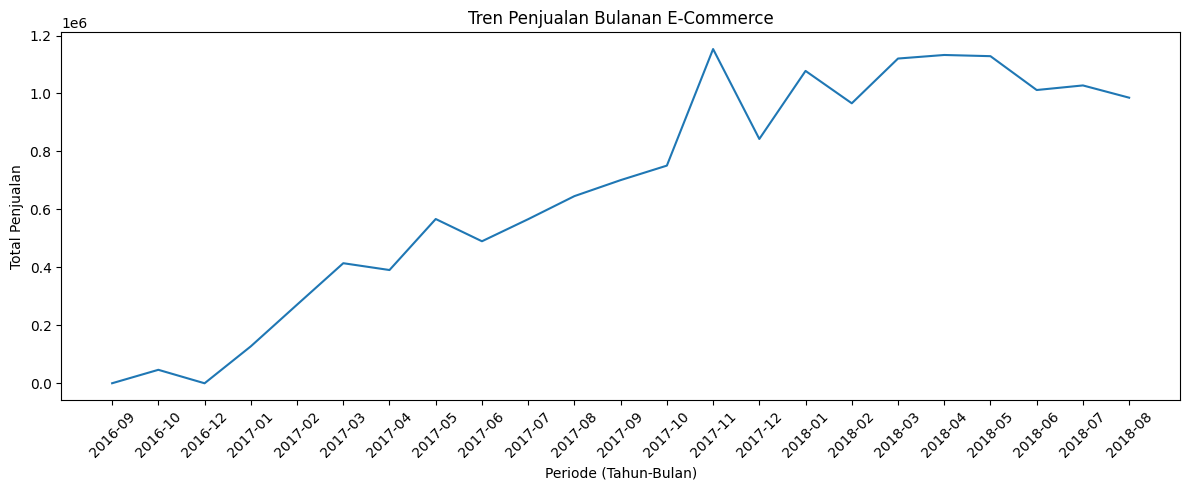

In [20]:
plt.figure(figsize=(12,5))
plt.plot(monthly_sales['order_year_month'], monthly_sales['total_sales'])
plt.xticks(rotation=45)
plt.title('Tren Penjualan Bulanan E-Commerce')
plt.xlabel('Periode (Tahun-Bulan)')
plt.ylabel('Total Penjualan')
plt.tight_layout()
plt.show()

**Insight:**

- Pertumbuhan Agresif: Terjadi tren kenaikan yang signifikan sejak awal 2017 hingga pertengahan 2018, menunjukkan skala bisnis yang berkembang pesat.

- Efek Seasonal (Puncak Promo): Terdapat lonjakan tajam pada November 2017, namun diikuti penurunan di bulan Desember.

- Fase Stabilisasi: Memasuki tahun 2018, total penjualan mulai stabil dan konsisten di angka >1 juta, menandakan basis pelanggan yang sudah terbentuk kuat.

In [21]:
category_sales = (
    df.groupby('product_category_name_english')['total_sales']
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .reset_index()
)

category_sales

,product_category_name_english,total_sales
0,health_beauty,1412089.53
1,watches_gifts,1264333.12
2,bed_bath_table,1225209.26
3,sports_leisure,1118256.91
4,computers_accessories,1032723.77
5,furniture_decor,880329.92
6,housewares,758392.25
7,cool_stuff,691680.89
8,auto,669454.75
9,garden_tools,567145.68


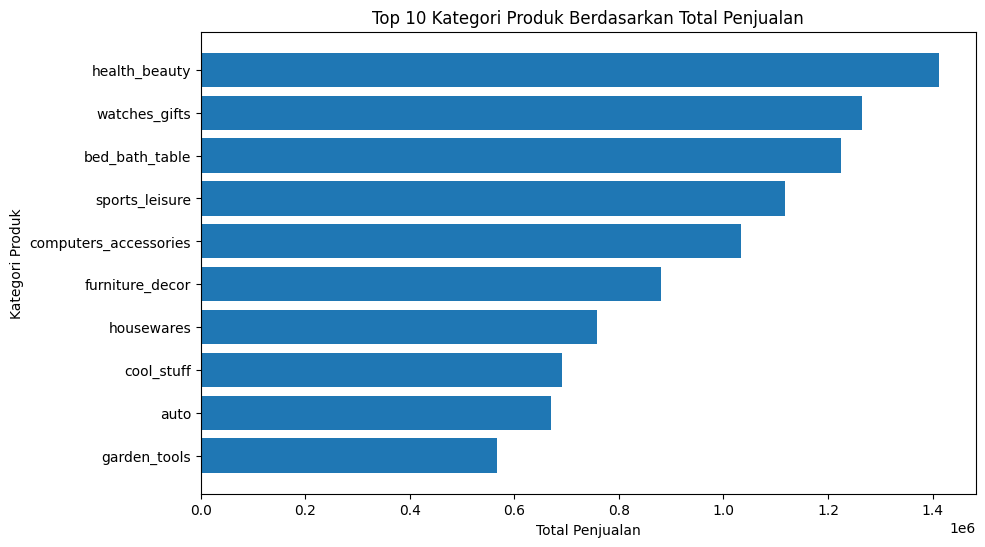

In [22]:
plt.figure(figsize=(10,6))
plt.barh(
    category_sales['product_category_name_english'],
    category_sales['total_sales']
)
plt.gca().invert_yaxis()
plt.title('Top 10 Kategori Produk Berdasarkan Total Penjualan')
plt.xlabel('Total Penjualan')
plt.ylabel('Kategori Produk')
plt.show()

**Insight:**
- Dominasi Health & Beauty: Kategori health_beauty menjadi kontributor pendapatan terbesar, menunjukkan tingginya permintaan pada produk perawatan diri (potensi repeat order tinggi).

- Kebutuhan Rumah Tangga & Gaya Hidup: Kategori seperti watches_gifts, bed_bath_table, dan sports_leisure melengkapi jajaran atas, menandakan platform ini banyak digunakan untuk belanja gaya hidup dan dekorasi rumah.

- Kategori Gadget: computers_accessories masuk dalam 5 besar, menunjukkan segmen teknologi juga memiliki pasar yang cukup besar di platform ini.

In [23]:
top_categories = category_sales['product_category_name_english'].tolist()

category_monthly = (
    df[df['product_category_name_english'].isin(top_categories)]
    .groupby(['order_year_month', 'product_category_name_english'])['total_sales']
    .sum()
    .reset_index()
)

category_monthly['order_year_month'] = category_monthly['order_year_month'].astype(str)
category_monthly.head()

,order_year_month,product_category_name_english,total_sales
0,2016-09,health_beauty,143.46
1,2016-10,auto,1351.27
2,2016-10,bed_bath_table,606.58
3,2016-10,computers_accessories,861.84
4,2016-10,cool_stuff,1236.88


## Visualization & Explanatory Analysis

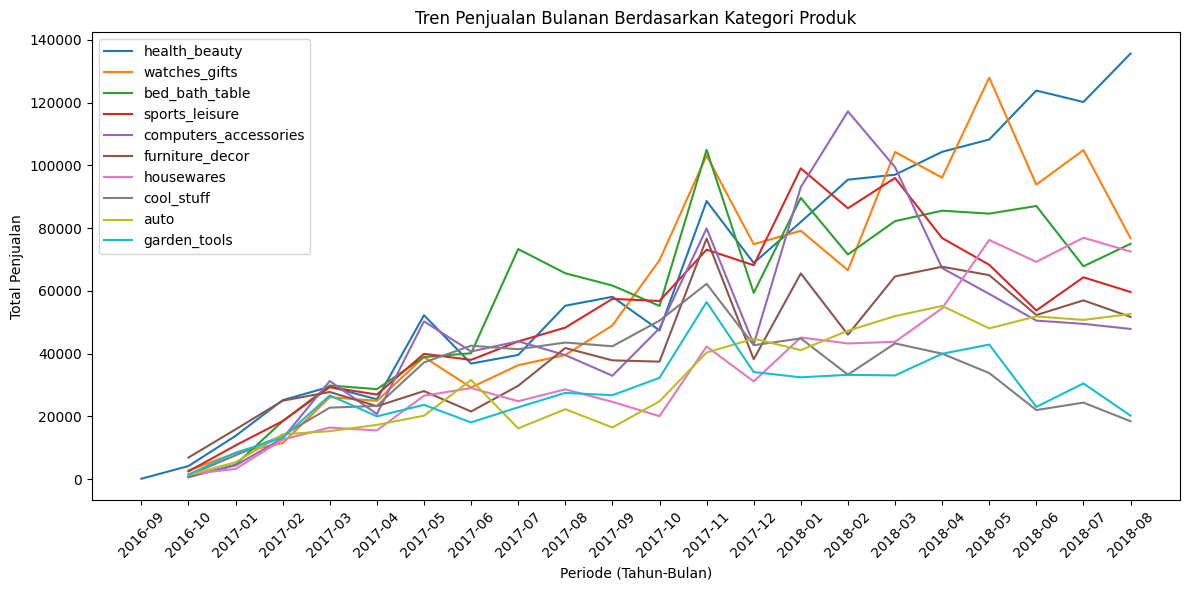

In [24]:
plt.figure(figsize=(12,6))

for category in top_categories:
    temp = category_monthly[
        category_monthly['product_category_name_english'] == category
    ]
    plt.plot(
        temp['order_year_month'],
        temp['total_sales'],
        label=category
    )

plt.xticks(rotation=45)
plt.title('Tren Penjualan Bulanan Berdasarkan Kategori Produk')
plt.xlabel('Periode (Tahun-Bulan)')
plt.ylabel('Total Penjualan')
plt.legend()
plt.tight_layout()
plt.show()

EDA - PERTANYAAN 2

In [25]:
snapshot_date = df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)
snapshot_date

Timestamp('2018-08-30 15:00:37')

In [26]:
rfm = (
    df.groupby('customer_unique_id')
      .agg({
          'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
          'order_id': 'nunique',
          'total_sales': 'sum'
      })
      .reset_index()
)

rfm.columns = ['customer_unique_id', 'recency', 'frequency', 'monetary']
rfm.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19
2,0000f46a3911fa3c0805444483337064,537,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89


In [27]:
rfm.describe()

,recency,frequency,monetary
count,93358.000000,93358.000000,93358.000000
mean,237.941773,1.033420,165.168210
std,152.591453,0.209097,226.292101
min,1.000000,1.000000,9.590000
25%,114.000000,1.000000,63.010000
50%,219.000000,1.000000,107.780000
75%,346.000000,1.000000,182.510000
max,714.000000,15.000000,13664.080000


In [28]:
rfm['R_score'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1])

# Robust fix for F_score due to highly skewed distribution
num_unique_frequencies = rfm['frequency'].nunique()

if num_unique_frequencies <= 1:
    rfm['F_score'] = 1 # Assign default score if no frequency variation
else:
    # Use qcut with a dynamic number of quantiles or fewer quantiles (e.g., 4) and handle duplicates
    # This aligns with the working solution in cell zaWMl0Zsj4Ob
    temp_f_score = pd.qcut(
        rfm['frequency'],
        q=4, # Adjusted quantiles due to skewed data
        labels=False, # Return integer indicators (0, 1, 2, 3...) instead of explicit labels
        duplicates='drop' # Drop non-unique bin edges if they occur
    )
    # Map the integer codes to desired scores (1, 2, 3, 4)
    rfm['F_score'] = temp_f_score + 1

rfm['M_score'] = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5])

In [29]:
def rfm_segment(score):
    if score >= 13:
        return 'Champions'
    elif score >= 10:
        return 'Loyal Customers'
    elif score >= 7:
        return 'Potential Loyalists'
    elif score >= 5:
        return 'At Risk'
    else:
        return 'Lost Customers'

# Calculate RFM_Score by summing the individual scores
rfm['RFM_Score'] = rfm[['R_score','F_score','M_score']].astype(int).sum(axis=1)

rfm['segment'] = rfm['RFM_Score'].apply(rfm_segment)

In [30]:
segment_dist = rfm['segment'].value_counts().reset_index()
segment_dist.columns = ['segment', 'customer_count']
segment_dist

,segment,customer_count
0,Potential Loyalists,44519
1,At Risk,25922
2,Loyal Customers,11534
3,Lost Customers,11383


## Visualization & Explanatory Analysis

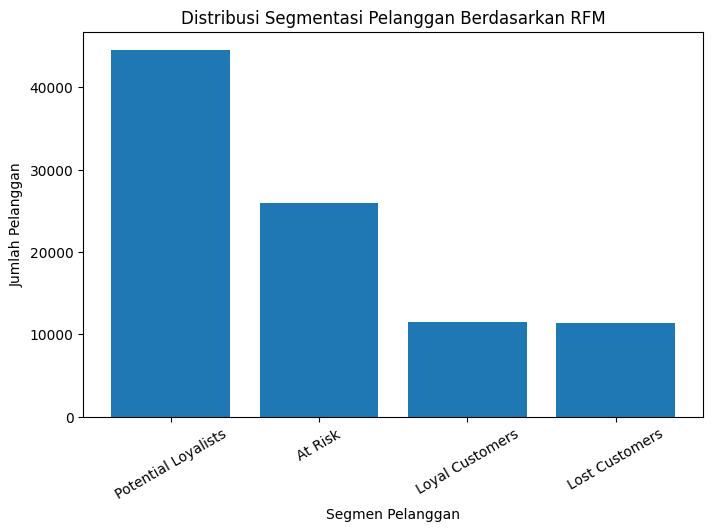

In [31]:
plt.figure(figsize=(8,5))
plt.bar(segment_dist['segment'], segment_dist['customer_count'])
plt.title('Distribusi Segmentasi Pelanggan Berdasarkan RFM')
plt.xlabel('Segmen Pelanggan')
plt.ylabel('Jumlah Pelanggan')
plt.xticks(rotation=30)
plt.show()

Analisis Segmentasi Pelanggan (RFM)

1. Dominasi Potential Loyalists
Observasi: Segmen terbesar adalah Potential Loyalists (>44.000 pelanggan).
Insight: Perusahaan berhasil mengakuisisi banyak pelanggan baru yang memiliki potensi untuk menjadi loyal. Ini adalah peluang besar untuk meningkatkan customer lifetime value.
2. Alarm pada Segmen At Risk
Observasi: Segmen At Risk menempati posisi kedua (~26.000 pelanggan).
Insight: Ada porsi pelanggan yang cukup besar yang sudah lama tidak bertransaksi. Jika tidak segera diintervensi dengan kampanye win-back, mereka akan beralih menjadi Lost Customers.
3. Rasio Loyalitas yang Perlu Ditingkatkan
Observasi: Jumlah Loyal Customers (~12.000) jauh lebih kecil dibandingkan Potential Loyalists.
Insight: Terdapat gap dalam strategi retensi. Perusahaan perlu mencari cara agar pelanggan "potensial" ini melakukan pembelian berulang secara konsisten hingga masuk ke kategori "loyal".
4. Rekomendasi Strategis (Actionable Insights)
Upselling untuk Potential Loyalists: Berikan program loyalitas atau poin reward untuk mendorong pembelian kedua dan ketiga.
Re-activation untuk At Risk: Kirimkan promo khusus "Kami merindukanmu" atau diskon terbatas untuk menarik mereka kembali bertransaksi.
Retention untuk Loyal Customers: Berikan akses eksklusif atau layanan VIP agar mereka tidak merasa diabaikan dan tetap bertahan.

In [32]:
rfm.groupby('segment')[['recency','frequency','monetary']].mean().round(2)

,recency,frequency,monetary
segment,,,
At Risk,305.80,1.01,84.65
Lost Customers,424.31,1.00,50.65
Loyal Customers,76.17,1.09,354.20
Potential Loyalists,192.69,1.04,192.36


## Conclusion

## Conclusion

Berdasarkan hasil analisis data e-commerce dapat disimpulkan bahwa:

1. Performa Bisnis & Momentum Pasar
Bisnis berhasil mencatat pertumbuhan eksponensial sejak 2017 dan mencapai stabilitas di angka penjualan tinggi pada 2018. Lonjakan masif pada bulan November menunjukkan efektivitas kampanye musiman (seasonal marketing).
2. Driver Utama Pendapatan
Health & Beauty serta produk Lifestyle (Watches & Home Decor) adalah mesin utama pendapatan. Fokus pada kategori ini terbukti berhasil menarik volume transaksi yang besar.
3. Tantangan Retensi Pelanggan (Gap Loyalitas)
Meskipun jumlah pelanggan baru (Potential Loyalists) sangat tinggi, jumlah pelanggan yang benar-benar Loyal masih relatif kecil.
Adanya segmen At Risk yang cukup besar (~26.000) menunjukkan risiko churn yang tinggi jika tidak segera dilakukan strategi re-aktivasi.